In [1]:
%matplotlib inline
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import rankdata

In [2]:
df = pd.read_csv('data/train.csv')

In [35]:
df.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,purpose,zip_code,dti,delinq_2yrs,...,RENT,Not Verified,Source Verified,Verified,issue_d_le,pymnt_plan_le,addr_state_le,earliest_cr_line_le,initial_list_status_le,application_type_le
0,15000.0,11.99,498.15,4,70000.0,1,0.589208,156,13.85,0.0,...,0,0,0,1,2013.750000,0,38,1991.916667,0,0
1,3725.0,6.03,113.38,0,52260.0,1,0.196499,339,19.43,0.0,...,0,0,1,0,2012.750000,0,9,2000.750000,0,0
2,16000.0,11.14,524.89,3,67500.0,1,0.589208,104,14.77,0.0,...,1,0,1,0,2013.250000,0,34,2001.500000,0,0
3,4200.0,13.33,142.19,1,21600.0,0,0.024302,982,39.00,0.0,...,0,1,0,0,2015.166667,0,47,2003.333333,1,0
4,6500.0,12.69,218.05,10,41000.0,1,0.196499,551,18.35,0.0,...,1,1,0,0,2012.000000,0,23,1990.666667,0,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 44 columns):
loan_amnt                     200189 non-null float64
int_rate                      200189 non-null float64
installment                   200189 non-null float64
emp_length                    200189 non-null int32
annual_inc                    200189 non-null float64
loan_status                   200189 non-null int64
purpose                       200189 non-null float64
zip_code                      200189 non-null int32
dti                           200189 non-null float64
delinq_2yrs                   200189 non-null float64
inq_last_6mths                200189 non-null float64
mths_since_last_delinq        200189 non-null float64
open_acc                      200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200189 non-null float64
total_acc                     2

In [5]:
df['is_title_known'] = df['emp_title'].map(lambda x: 0 if x == 'n/a' else 1)
df.drop('emp_title', axis=1, inplace=True)

In [6]:
df['is_delinq_occurs'] = df['mths_since_last_delinq'].map(lambda x: 0 if math.isnan(x) else 1)

max_mths_since_last_delinq = np.nanmax(df.mths_since_last_delinq.values)
df['mths_since_last_delinq'].fillna(max_mths_since_last_delinq, inplace=True)

In [7]:
df.revol_util.fillna(value=0,inplace=True)
df.collections_12_mths_ex_med.fillna(value=0,inplace=True)
df.tot_coll_amt.fillna(value=0,inplace=True)
df.tot_cur_bal.fillna(value=0,inplace=True)
df.total_rev_hi_lim.fillna(value=0,inplace=True)

In [8]:
def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

In [9]:
term_le_encoder = encode_with_LabelEncoder(df,'term')

In [10]:
grade_le_encoder = encode_with_LabelEncoder(df,'grade')
sub_grade_le_encoder = encode_with_LabelEncoder(df,'sub_grade')

In [11]:
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

In [12]:
one_hot_encoded_home_ownership = pd.get_dummies(df.home_ownership)
df = df.drop('home_ownership',axis = 1)

df = df.join(one_hot_encoded_home_ownership)

In [13]:
one_hot_encoded_verification_status = pd.get_dummies(df.verification_status)
df = df.drop('verification_status',axis = 1)

df = df.join(one_hot_encoded_verification_status)

In [14]:
def month_to_decimal(month):
    month_dict = {'Jan':0, 'Feb':1/12., 'Mar':2/12., 'Apr':3/12., 'May':4/12., 'Jun':5/12., 
     'Jul':6/12., 'Aug':7/12., 'Sep':8/12., 'Oct':9/12., 'Nov':10/12., 'Dec':11/12.}
    return month_dict[month]

def convert_date(month_year):
    month_and_year = month_year.split('-')
    return float(month_and_year[1]) + month_to_decimal(month_and_year[0])
def encode_with_func(df, column_name, func_name):
    df[column_name+'_le'] = df[column_name].map(func_name)
    df.drop(column_name, axis=1, inplace=True)

encode_with_func(df, 'issue_d', convert_date)

In [15]:
pymnt_plan_le_encoder = encode_with_LabelEncoder(df,'pymnt_plan')

In [16]:
encoding = df.groupby('purpose').size()
encoding = encoding / len(df)
df['purpose'] = df.purpose.map(encoding)

In [17]:
addr_state_le_encoder = encode_with_LabelEncoder(df,'addr_state')

In [18]:
encode_with_func(df, 'earliest_cr_line', convert_date)

In [19]:
initial_list_status_le_encoder = encode_with_LabelEncoder(df,'initial_list_status')

In [20]:
application_type_le_encoder = encode_with_LabelEncoder(df,'application_type')

In [21]:
df['zip_code'] = df['zip_code'].where(df['zip_code'].str.len() == 4, 
                                               df['zip_code'].str[:3])
df['zip_code'] = df['zip_code'].astype(int)

In [22]:
Y = df['loan_status'].values

X = df.drop(['loan_status'], axis=1)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l1',random_state=42)
classifier.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(penalty = 'l2',random_state=42)
classifier1.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
y_pred = classifier.predict(x_test)

In [27]:
y_pred1 = classifier1.predict(x_test)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm1 = confusion_matrix(y_test,y_pred1)

In [29]:
cm

array([[ 1450, 11821],
       [ 1230, 45556]], dtype=int64)

In [30]:
cm1

array([[ 1451, 11820],
       [ 1230, 45556]], dtype=int64)

In [31]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7826897780441914
Precision: 0.7939766805514404
Recall: 0.9737100842132261


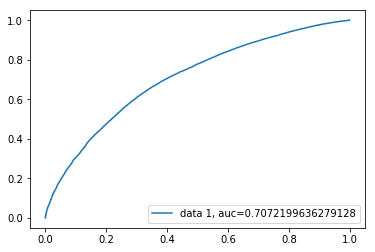

In [33]:
y_pred_proba = classifier.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
